# Text Insight Analyzer (Telecom dataset)

> All rights Reserved \
> 2025 [Israel Llorens](https://www.linkedin.com/in/israel-llorens/) \
> [GitHub/sanchezis](https://github.com/sanchezis/text-insights-analyzer)

# 0. Loading libraries

In [1]:
import init

from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer

from Framework.spark import spark

import Framework.sampledf as dfs

from Framework.nlp.tokenize import *
from Framework.nlp.regex import *
from Framework.utils.plot import *

25/05/25 22:48:12 WARN Utils: Your hostname, Airon.local resolves to a loopback address: 127.0.0.1; using 192.168.100.57 instead (on interface en0)
25/05/25 22:48:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 22:48:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Dataset Sourcing

In [2]:
dataset = dfs.telecom_200k()

In [3]:
dataset.show(truncate=False)

+--------------------------------+-------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|conversation_id                 |speaker|date_time                 |text                                                                                                                                                                                                                                                                                                                                                                                

Load the data (there are 200K conversations so we need to choose a sample to work on our cluster), less than 2% !!

In [4]:
df = dataset.join(
        dataset.select('conversation_id').groupby('conversation_id').count().sample(.018, seed=42),
        on=['conversation_id']
    )

Quickly check the dataset size and complete conversations cohort

In [5]:
df.count(), df.select('conversation_id').distinct().count()

(67072, 4104)

Quickly investigate the loaded dataset

In [6]:
conversation_id = df.sample(.25, seed=42).first().conversation_id
one = df.filter( F.col('conversation_id') == conversation_id).sort('date_time')
one

conversation_id,speaker,date_time,text,count
87c3e19c7a7945a0b...,agent,2023-12-20 18:54:16,"Hello, thank you ...",13
87c3e19c7a7945a0b...,client,2023-12-20 18:54:...,"Hi Noe, I'm calli...",13
87c3e19c7a7945a0b...,agent,2023-12-20 18:54:...,"Of course, Iinton...",13
87c3e19c7a7945a0b...,client,2023-12-20 18:54:...,"Sure, my account ...",13
87c3e19c7a7945a0b...,agent,2023-12-20 18:54:...,"Great, thank you ...",13
87c3e19c7a7945a0b...,client,2023-12-20 18:54:...,The charge was on...,13
87c3e19c7a7945a0b...,agent,2023-12-20 18:55:...,I apologize for t...,13
87c3e19c7a7945a0b...,client,2023-12-20 18:55:...,"Yes, my email add...",13
87c3e19c7a7945a0b...,agent,2023-12-20 18:55:...,"Thank you, Quinto...",13
87c3e19c7a7945a0b...,client,2023-12-20 18:55:...,"No, that's all. T...",13


# 2. Problem Definition

The dataset consists of transcripts from customer and expert interactions. A key challenge lies in accurately identifying the customer’s intent—or multiple intents—throughout the entire conversation flow.

Additionally, it's difficult to evaluate the outcome of these interactions: whether the expert successfully resolved the issue, ended the call appropriately with a closing statement, or if the conversation was abruptly cut off.

Other areas of interest include detecting high levels of customer dissatisfaction, recognizing negative language from either party, and identifying cases where the expert's handling may have contributed to unresolved issues—potentially indicating a need for additional coaching or training.

This analysis aims to extract meaningful insights from the transcripts to help answer these questions and uncover patterns that could inform decision-making and process improvement

## Preprocess Text data

Lets pre-process the text data and keep it in a __cleaned__ format

In [7]:
re.findall(NAME_REGEX, "my name is Laura")

['my name is Laura']

In [8]:
re.findall(NAME_REGEX, "Hi, my name is Laura") 

['Hi, my name is Laura']

One of the most relevant situations is that when we want to analyze and extract topics, the names are elements that needs to be avoided. Here I am introducing a regex to try to find all the common openings, to detect names, but of course there are better ways to identify them and eliminate for better outcome. We will discuss these options in the `next steps` section.

In [9]:
@F.udf( T.StringType() )
def unique_text (x):
    try:
        if not x: return None
        x = x.split(' ')
        return ' '.join(list(dict.fromkeys(x)))
    except:
        return None

df_preprocessed = ( df
                    .withColumn('text', 
                                F.regexp_replace(
                                    'text', 
                                    pattern = r'(?i)\bto\s+(union.*?mobile)\b|\b(union.*?mobile)\b', 
                                    replacement='') 
                                )
                    .withColumn('text',
                                F.regexp_replace(
                                    'text',
                                    pattern = NAME_REGEX,
                                    replacement = ''
                                )
                                )
                    .withColumn('__text__',
                                F.when(
                                        F.col('text')
                                        .rlike(
                                            '|'.join([
                                            bb_ss_pattern,
                                            bb_loyalty_pattern,
                                            bb_tech_pattern,
                                            bb_greeting_pattern,
                                            bb_closing_pattern,
                                            bb_general_pattern])
                                        ), F.col('text')
                                    )
                                .otherwise(None)
                                )
)
df_preprocessed = extract_tokens(df_preprocessed, '__text__')
df_preprocessed = df_preprocessed.withColumn('__cleaned__', unique_text('__cleaned__'))

Several strategies here applied, we can either use the text, trying to remove People Names using REGEX, or choose those text's where there are at least any of the most interesting regex words applied for the Business Knowledge.

In [10]:
df_preprocessed.show(n=30, truncate=False)

+--------------------------------+-------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|conversation_id                 |speaker

We’ll use the spaCy library to perform lemmatization, ensuring that words are normalized to their base forms. This helps maintain consistent language structure, which is especially useful for downstream tasks like topic clustering.

For topic modeling, we’ll apply Latent Dirichlet Allocation (LDA). This algorithm is well-suited for analyzing customer-agent transcripts, as it helps uncover:

- Common issue categories (e.g., billing, technical support, shipping)
- Conversations that shift across topics (e.g., starting with billing, moving to technical)
- Agent behavior patterns or areas of specialization
- Emerging or trending topics over time

When combined with sentiment analysis, this approach will allow us to extract richer insights by reducing word vectors to their most meaningful components. This, in turn, will help us track how conversations evolve—whether topics shift naturally throughout the call, or whether multiple issues are discussed in a single interaction.

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer

import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Load spaCy model (run once: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@udf(returnType=ArrayType(StringType()))
def spacy_lemmatize(text):
    try:
        if text:
            doc = nlp(text)
            # Get lemmas, excluding stop words and punctuation
            return [token.lemma_.lower() for token in doc 
                    if not token.is_stop and not token.is_punct and token.is_alpha and not token.ent_type_ == "PERSON"]
        return []
    except:
        return None

# Apply directly to text (combines tokenization + lemmatization)
df_tokenize = df_preprocessed.withColumn("__lemmatized__", F.concat_ws(' ' ,spacy_lemmatize("__cleaned__")) )

stopwords=[]

df_tokenize = tokenize(df_tokenize, cleaned='__lemmatized__', stopwords=stopwords).cache()

df_filtered = (
    df_tokenize.withColumn("__lda_ready__", 
        # Remove very short words (< 3 chars)
        F.expr("filter(__filtered_tokens__, x -> length(x) >= 3)"))
        # Could also add: frequency filtering, n-gram creation
    ).cache()

In [14]:
df_filtered.show(3, truncate=False)

+--------------------------------+-------+--------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|conversation_id                 |speaker|date

In [13]:
df_filtered.count(), df_filtered.select('conversation_id').distinct().count()

(64045, 3986)

We are having around 64K text transcripts for almost 4K unique calls.

## Sentiment extraction

For sentiment detection, we will leverage a pre-trained model from Hugging Face:

- `model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"`

Which is effective at classifying text into three sentiment categories

- Negative, Neutral, and Positive.

While this lightweight model is suitable for fast prototyping and initial insights, for production-grade performance we can consider integrating more advanced large language models (LLMs), potentially via API-based solutions. 

This would allow for deeper sentiment understanding, better contextual awareness, and enhanced accuracy across diverse customer interactions.

The model is kept within the same UDF structure so that the cluster can operate accordingly if the attribute is set.

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

import transformers
transformers.logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore", message="")

from pyspark.sql.functions import pandas_udf
import pandas as pd


@pandas_udf(returnType=StructType([
    StructField("sentiment", StringType()),
    StructField("score", FloatType())
]))
def sentiment_batch(texts: pd.Series) -> pd.DataFrame:
    # Get broadcast variables    
    
    # Cache model in function attribute (loads once per executor)
    if not hasattr(sentiment_batch, 'local_model'):
        model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # General purpose, constantly up to date (latest)
        sentiment_batch.tokenizer = AutoTokenizer.from_pretrained(model_name)
        sentiment_batch.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        sentiment_batch.model.eval()    
    
    local_tokenizer = sentiment_batch.tokenizer
    local_model = sentiment_batch.model
    
    sentiments = []
    scores = []
    
    # Process in batches
    BATCH_SIZE = 32
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i+BATCH_SIZE].tolist()
        
        # Tokenize batch
        inputs = local_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        
        # Get predictions
        with torch.no_grad():
            outputs = local_model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Process results
        for j, pred in enumerate(predictions):
            # For binary models (POSITIVE/NEGATIVE)
            # pred[0] = negative probability, pred[1] = positive probability
            
            # pos_score = pred[1].item()
            neg_score = pred[0].item()    # NEGATIVE probability
            neu_score = pred[1].item()    # NEUTRAL probability  
            pos_score = pred[2].item()    # POSITIVE probability

            # Get the class with highest probability
            max_idx = torch.argmax(pred).item()

            if max_idx == 2:  # POSITIVE
                sentiment = "POSITIVE"
                score = pos_score
            elif max_idx == 0:  # NEGATIVE
                sentiment = "NEGATIVE"
                score = neg_score
            else:  # NEUTRAL
                sentiment = "NEUTRAL"
                score = neu_score
            
            sentiments.append(sentiment)
            scores.append(score)
    
    return pd.DataFrame({
        'sentiment': sentiments,
        'score': scores
    })


def sentiment_extraction(df, column):
    optimal_partitions = spark.sparkContext.defaultParallelism * 2
    
    df = df.filter(F.col(column).isNotNull() & (F.length(F.col(column)) > 0))
    df = df.repartition(optimal_partitions).cache()

    # Configure Spark for better performance
    spark.conf.set("spark.sql.adaptive.enabled", "true")
    spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

    # Apply pandas UDF
    return df\
                        .withColumn("sentiment_result", sentiment_batch(F.col(column))) \
                        .withColumn("sentiment", F.col("sentiment_result.sentiment")) \
                        .withColumn("sentiment_score", F.col("sentiment_result.score")) \
                        .drop("sentiment_result")

df_with_sentiment = sentiment_extraction(df_filtered, "text")

In [19]:
df_with_sentiment.show(3, truncate=False)

+--------------------------------+-------+--------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Use LDA as topic cluster

As commented before, we will use LDA. We have tested the algorithm and found a decent amount of topics to be 10. We will use this `k` value for our research from now on, and later will discuss the other alternatives. 

In [21]:
# Vectorization for LDA
cv = CountVectorizer(
    inputCol="__lda_ready__",
    outputCol="raw_features",
    vocabSize=2000,
    minDF=3,         # Reduced minDF to keep more distinctive terms
    maxDF=0.7        # Remove terms that appear in >70% of documents
)

cv_model = cv.fit(df_with_sentiment)
df_vectorized = cv_model.transform(df_with_sentiment)
cv_vocab = cv_model.vocabulary

It is possible to use IDF to just select better vocabulary, by investigating which are the words that appear the most over the documents (Term frequency) but after trying, this option is not OPTIMAL for our use case.

In [18]:
idf = IDF(inputCol="raw_features", outputCol="tfidf")
idf_model = idf.fit(df_vectorized)
df_vectorized = idf_model.transform(df_vectorized)

def sparse_to_pairs(v):
    return list(zip(v.indices.tolist(), v.values.tolist()))

sparse_to_pairs_udf = udf(sparse_to_pairs, ArrayType(StructType([
    StructField("index", IntegerType(), False),
    StructField("value", FloatType(), False)
])))

df_vectorized_tfidf = df_vectorized.withColumn("tfidf_pairs", sparse_to_pairs_udf(F.col("tfidf")))

pairs = df_vectorized_tfidf.select(F.explode(F.col("tfidf_pairs")).alias("pair"))
pairs = pairs.select(F.col("pair.index").alias("index"), F.col("pair.value").alias("score"))

avg_scores = pairs.groupBy("index").avg("score").withColumnRenamed("avg(score)", "avg_score")

# Select top-N scoring tokens
N = 1000
sorted_tokens = avg_scores.orderBy(F.col("avg_score").desc()).limit(N).collect()
selected_indices = [idx for idx, _ in sorted_tokens]
selected_vocab = [cv_vocab[idx] for idx in selected_indices]

print(selected_vocab[:10])

from pyspark.ml.feature import CountVectorizerModel

cv = CountVectorizerModel.from_vocabulary(
    selected_vocab,
    inputCol="__lda_ready__",
    outputCol="features",
)

df_vectorized_tfidf = cv.transform(df_vectorized)
cv_vocab = selected_vocab

['kelley',
 'pleaset',
 'arere',
 'decent',
 'shirley',
 'onem',
 'radiation',
 'estelle',
 'unsure',
 'tommie']

In [ ]:
# LDA with optimized settings
lda = LDA(
            # k=5, 
            k=10,                          # Try more topics
            # maxIter=10,
            maxIter=50,                     # More iterations
            # optimizer="em",               # "online" for streamed large data
            optimizer="online",             # Better for larger datasets
            featuresCol="raw_features",     # using raw_features instead of "features" so that we use the **CountVectorizer + LDA together** 
            seed=42,                        # For reproducibility
            optimizeDocConcentration=True,  # Auto-tune alpha
        )     

lda_model = lda.fit(df_vectorized)
df_topics = lda_model.transform(df_vectorized)

In [23]:
topics = lda_model.describeTopics(maxTermsPerTopic=15)  # More terms
vocabulary = cv_model.vocabulary

# Calculate topic coherence and filter similar topics
def analyze_topic_quality(topics_df, vocabulary):
    topic_info = {}
    
    for row in topics_df.collect():
        topic_id = row.topic
        term_indices = row.termIndices
        term_weights = row.termWeights
        
        # Get words with their weights
        topic_terms = [(vocabulary[idx], weight) for idx, weight in zip(term_indices, term_weights)]
        
        # Filter out very low-weight terms
        significant_terms = [(term, weight) for term, weight in topic_terms if weight > 0.01]
        
        topic_info[topic_id] = {
            'terms': [term for term, _ in significant_terms[:10]],
            'weighted_terms': significant_terms[:10],
            'top_terms_str': ", ".join([term for term, _ in significant_terms[:8]])
        }
    
    return topic_info

topic_analysis = analyze_topic_quality(topics, vocabulary)

print("=== TOPIC ANALYSIS ===")
for topic_id, info in topic_analysis.items():
    print(f"\nTopic {topic_id}:")
    print(f"Top terms: {info['top_terms_str']}")
    print("Terms with weights:")
    for term, weight in info['weighted_terms'][:5]:
        print(f"  {term}: {weight:.4f}")

=== TOPIC ANALYSIS ===

Topic 0:
Top terms: fix, goodbye, fine, care, sigh, time, phone, service
Terms with weights:
  fix: 0.0277
  goodbye: 0.0274
  fine: 0.0227
  care: 0.0167
  sigh: 0.0164

Topic 1:
Top terms: plan, like, datum, international, offer, think, account, need
Terms with weights:
  plan: 0.0530
  like: 0.0301
  datum: 0.0297
  international: 0.0166
  offer: 0.0154

Topic 2:
Top terms: help, thank, okay, sound, think, issue, good, yes
Terms with weights:
  help: 0.2494
  thank: 0.2257
  okay: 0.0671
  sound: 0.0341
  think: 0.0289

Topic 3:
Top terms: gift, card, machine, cloud, speak, digital, supervisor, learning
Terms with weights:
  gift: 0.0532
  card: 0.0489
  machine: 0.0271
  cloud: 0.0260
  speak: 0.0222

Topic 4:
Top terms: assist, today, able, team, transfer, issue, help, support
Terms with weights:
  assist: 0.1266
  today: 0.0977
  able: 0.0332
  team: 0.0299
  transfer: 0.0290

Topic 5:
Top terms: great, day, welcome, bye, alright, enjoy, goodbye
Terms with

In [24]:
df_topics.show(5)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

+--------------------+-------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+
|     conversation_id|speaker|           date_time|                text|count|            __text__|         __cleaned__|      __lemmatized__| __filtered_tokens__|          __ngrams__|       __lda_ready__|sentiment|sentiment_score|        raw_features|   topicDistribution|
+--------------------+-------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+
|6a5fa45112854875b...|  agent|2023-12-15 11:32:...|. Now, can you te...|   17|. Now, can you te...| now can you tell...|tell little bit b...|[tell, little, bi...|[tell little, lit..

with the proposed topics we can see that there is a clear pattern to group them into proper group calls

Greetings & Closings:
- Topic 5: closing/greeting pattern (great: 0.35, day: 0.28, welcome: 0.07, bye: 0.02)
- Topic 9: Follow-up closing (question: 0.09, concern: 0.07, reach: 0.07, great: 0.06, day: 0.05)

Technical Support:
- Topic 0: Technical resolution (fix: 0.03, phone: service - likely call endings after tech support)
- Topic 6: Account troubleshooting (issue: 0.04, check: 0.04, account: 0.03, try: look)
- Topic 8: Device support (device: 0.03, try: 0.02, phone: 0.02, app: work: use)

Billing/Service/Sales:
- Topic 1: Plan discussions offer account (plan: 0.05, international: 0.02, offer: 0.02, account: need)

General Support:
- Topic 2: General assistance (help: 0.25, thank: 0.23 - highest weights indicate core support)
- Topic 4: Support Team (assist: 0.13, today: 0.10, team: 0.03, transfer: 0.03)
- Topic 7: Problems (tell: help: issue: understand)

Escalations:
- Topic 3: Escalation/specialized (gift: card: supervisor: speak - mixed specialized terms)

In [38]:
from pyspark.ml.functions import vector_to_array

@F.udf(returnType=T.IntegerType())
def get_dominant_topic(topic_dist, threshold=0.3):
    """Only assign dominant topic if confidence is above threshold"""
    if topic_dist:
        max_prob = float(max(topic_dist))
        if max_prob >= threshold:
            return int(np.argmax(topic_dist))
    return -1  # No dominant topic

df_topics = (
        df_topics
            .withColumn("topic_array",          vector_to_array("topicDistribution"))
            .withColumn("dominant_topic_id",     F.expr("array_position(topic_array, array_max(topic_array)) - 1"))
            .withColumn("dominant_topic",       get_dominant_topic(F.col("topicDistribution")))
            .withColumn("topic", 
                        F
                        .when(F.col("dominant_topic")    == -1, "")
                        .when(F.col("dominant_topic_id") == 0, "Technical Solution")
                        .when(F.col("dominant_topic_id") == 1, "Billing Plans")
                        .when(F.col("dominant_topic_id") == 2, "General Support")
                        .when(F.col("dominant_topic_id") == 3, "Escalation")
                        .when(F.col("dominant_topic_id") == 4, "Technical Dispatch")
                        .when(F.col("dominant_topic_id") == 5, "Call Closing")
                        .when(F.col("dominant_topic_id") == 6, "Account Checking")
                        .when(F.col("dominant_topic_id") == 7, "Issue Troubleshoot")
                        .when(F.col("dominant_topic_id") == 8, "Technical Support")
                        .when(F.col("dominant_topic_id") == 9, "Follow Up")
                        .otherwise("Unknown")
            )
            .drop("topic_array")
)

In [39]:
df_topics.show(5, truncate=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

+--------------------------------+-------+--------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----

The following part of code is just to bring up the most important topic within the set of topics inside the LDA separation. It helps later to see how confident the LDA is confident in choosing the selected topic. It sees how confident the model was in its assignment.

In [70]:
df_with_topics = (
    df_topics
        .withColumn(
            "max_topic_prob",
            F.udf(lambda x: float(max(x)) if x else 0.0, T.DoubleType())(F.col("topicDistribution"))
        )
)

# Create improved topic description UDF
@F.udf(returnType=StringType())
def get_topic_description(topic_id):
    if topic_id in topic_analysis and topic_id != -1:
        return topic_analysis[topic_id]['top_terms_str']
    return "No dominant topic"

df_final = (
    df_with_topics
        .withColumn(
            "topic_words", 
            get_topic_description(F.col("dominant_topic"))
        )
    )

# Get dominant topic value from sparse vector
@F.udf(T.FloatType())
def get_dominant_topic_value(vec):
    if vec:
        max_idx = vec.argmax()
        return float(vec[max_idx])
    return 0.0

df_final = (
    df_final
        .withColumn( "dominant_topic_value",  get_dominant_topic_value("topicDistribution"))
        .cache()
    )

## Show or store the Final Result

In [34]:
import shutil

# shutil.rmtree('df_final.parquet')
# df_final.write.parquet('df_final.parquet')

# df_final.write.parquet('df_final.parquet')

In [41]:
# View with all topic info
df_final.select("__lemmatized__", 'topic', 
                "dominant_topic", "dominant_topic_id", 
                "dominant_topic_value", "topic_words", 
                "sentiment", "sentiment_score")\
        .show(15, truncate=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

+------------------------------------------------------------------------------------------------------------------------------------------------+------------------+--------------+-----------------+--------------------+--------------------------------------------------------+---------+---------------+
|__lemmatized__                                                                                                                                  |topic             |dominant_topic|dominant_topic_id|dominant_topic_value|topic_words                                             |sentiment|sentiment_score|
+------------------------------------------------------------------------------------------------------------------------------------------------+------------------+--------------+-----------------+--------------------+--------------------------------------------------------+---------+---------------+
|tell little bit business currently data plan help well understand need find good solution 

# 3. Find optimal topics LDA(k) / EVALUATE MODEL

In [42]:
print("\n=== SAMPLE RESULTS ===")
df_final\
    .select(
        "text", 
        # "topic",
        "dominant_topic", 
        "max_topic_prob",
        "topic_words")\
    .filter(F.col("dominant_topic") != -1  # Only show documents with clear dominant topics
        )\
    .show(10, truncate=False)

# Show topic distribution
print("\n=== TOPIC DISTRIBUTION ===")
(
    df_final
        # .withColumn('topic', 
        #             F.when( F.col('dominant_topic')==-1, 'Unknown').otherwise(F.col('topic')))
        .groupBy([
            # "topic", 
            "dominant_topic"
            ])
        .count()
        .orderBy("dominant_topic")
        .show()
)


=== SAMPLE RESULTS ===
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+-------------------+--------------------------------------------------------+
|text                                                                                                                                                                                                                                                                             |dominant_topic|max_topic_prob     |topic_words                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

+--------------+-----+
|dominant_topic|count|
+--------------+-----+
|            -1|25183|
|             0| 1500|
|             1| 5264|
|             2| 4689|
|             3|  146|
|             4| 5917|
|             5| 3430|
|             6| 7216|
|             7| 4972|
|             8| 4392|
|             9| 1336|
+--------------+-----+



It is normal to see in this case higher amount of -1 as those dominant topics are coming from the LDA where the text was removed DUE to the initial selected regex that belongs to the Business Use Case. If we need to look for all the cases, this value should be as minimum as possible.

In [44]:
# EVALUATE K=10 CHOSEN MODEL QUALITY
log_likelihood = lda_model.logLikelihood(df_vectorized)
log_perplexity = lda_model.logPerplexity(df_vectorized)

print(f"\n=== MODEL METRICS ===")
print(f"Log Likelihood: {log_likelihood}")
print(f"Log Perplexity: {log_perplexity}")

##################################################################
def evaluate_different_k_values(df_vectorized, k_values=[3, 5, 7, 10, 12, 14, 18, 24]):
    """Evaluate different numbers of topics"""
    results = []
    
    for k in k_values:
        lda_temp = LDA(k=k, maxIter=20, optimizer="online", featuresCol="raw_features", seed=42)
        model_temp = lda_temp.fit(df_vectorized)
        
        ll = model_temp.logLikelihood(df_vectorized)
        lp = model_temp.logPerplexity(df_vectorized)
        
        results.append({
            'k': k,
            'log_likelihood': ll,
            'log_perplexity': lp
        })
        
        print(f"k={k}: Log-Likelihood={ll:.2f}, Log-Perplexity={lp:.2f}")
    
    return results

k_results = evaluate_different_k_values(df_vectorized)


=== MODEL METRICS ===
Log Likelihood: -2025307.2041116687
Log Perplexity: 5.850428544927852
k=3: Log-Likelihood=-2072603.99, Log-Perplexity=5.99
k=5: Log-Likelihood=-2051715.06, Log-Perplexity=5.93
k=7: Log-Likelihood=-2059702.37, Log-Perplexity=5.95
k=10: Log-Likelihood=-2062590.11, Log-Perplexity=5.96
k=12: Log-Likelihood=-2085202.65, Log-Perplexity=6.02
k=14: Log-Likelihood=-2109661.85, Log-Perplexity=6.09
k=18: Log-Likelihood=-2126870.19, Log-Perplexity=6.14
k=24: Log-Likelihood=-2180749.02, Log-Perplexity=6.30


### Show metrics from k Results

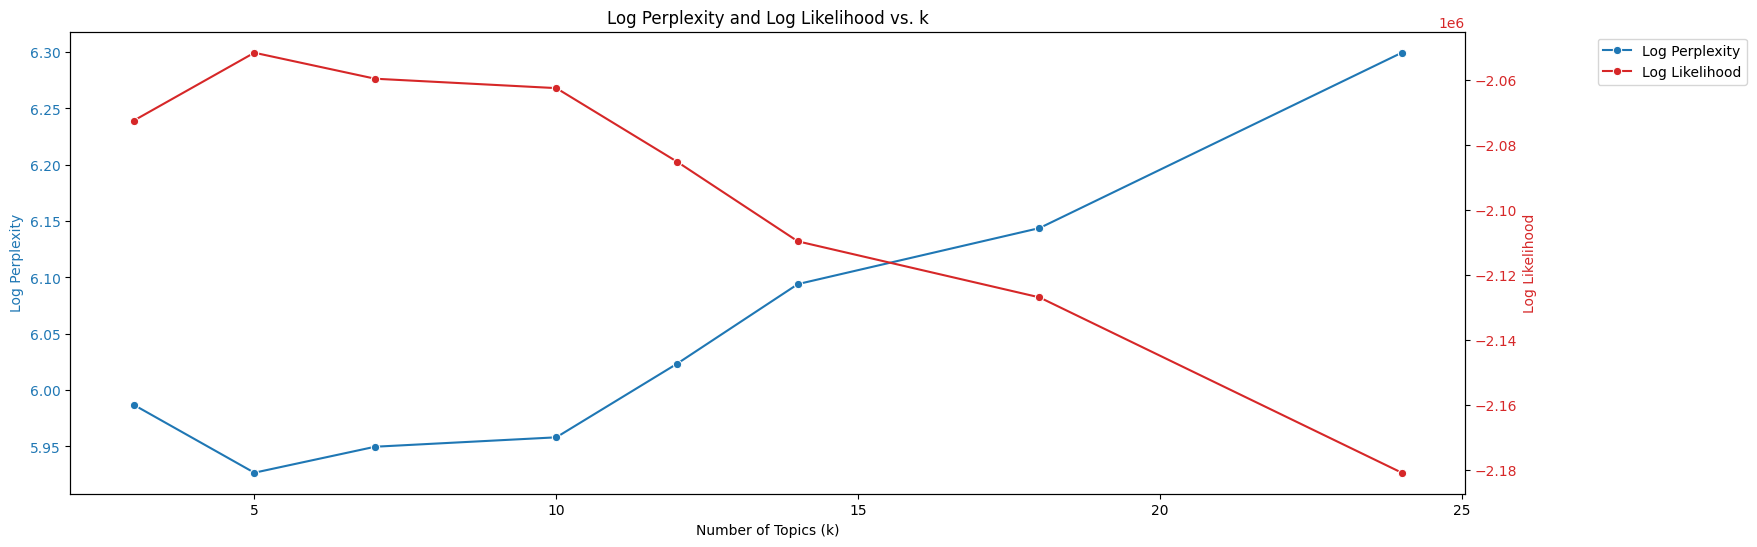

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(k_results)

# Create the figure and the primary y-axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot log perplexity on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('Log Perplexity', color=color)
sns.lineplot(x='k', y='log_perplexity', data=data, marker='o', color=color, ax=ax1, label='Log Perplexity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
# ax1.legend(loc='lower right')

# Create the secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Likelihood', color=color)
sns.lineplot(x='k', y='log_likelihood', data=data, marker='o', color=color, ax=ax2, label='Log Likelihood')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(loc='lower left')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.09, 1), loc='upper left')
ax1.get_legend().remove() # Remove the first legend

plt.title('Log Perplexity and Log Likelihood vs. k')
# fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Looking at the model evaluation results, the optimal number of topics falls within the [5-10] range. This is where we see the lowest perplexity scores (indicating better predictive performance) combined with sufficiently high log-likelihood values (showing good fit to the document corpus).

# 4. Bring some Insights

In [49]:
bar( df_final.groupBy("topic").count().filter(F.col('topic')!='').sort("count", ascending=False), 'count', 'topic')

<h4> 
Model k=10 log perplexity shows decent coherence (5.96) with good separation between topics.
<br/><br/>
If we continuously increment `k` will eventually lead to overfitting, where topics become too specific and loose generalized ability.
<br/><br/>
We need to choose the proper balance. That is the reason why we choose k=10 technically performs decent on training metrics, k=10 provides a more parsimonious model with sufficient topic separation for practical interpretation. The trade-off between model complexity and interpretability suggests k=10 remains the optimal choice for this call transcript analysis.

</h4>

## Insights from best model

In [53]:
bar(df_final.groupBy('sentiment').count(), 'count', 'sentiment')

Very interesting to see more Positives that Negatives, that tells at least that overall speaking the calls are performing good.

In [54]:
bar(df_final.filter(F.col('speaker') == 'agent').groupBy('sentiment').count(), 'count', 'sentiment')

Agents are usually POSITIVE! we need to take care on those NEGATIVE ONES!

In [55]:
bar(df_final.filter(F.col('speaker') != 'agent').groupBy('sentiment').count(), 'count', 'sentiment')

We are having customers that are with POSITIVE impact, but there are more number of NEGATIVE compared to the agents. (4K vs 6K) !

In [71]:
import pyspark.sql.window as W

from pyspark.sql.types import ArrayType, StringType

@F.udf(returnType=ArrayType(StringType()))
def remove_consecutive_duplicates(sentiment_array):
    if not sentiment_array or len(sentiment_array) <= 1:
        return sentiment_array
    
    result = [sentiment_array[0]]  # Always keep the first element
    
    for i in range(1, len(sentiment_array)):
        if sentiment_array[i] != sentiment_array[i-1]:  # Different from previous
            result.append(sentiment_array[i])
    
    return result

window = W.Window().partitionBy(['conversation_id', 'speaker']).orderBy('date_time').rangeBetween( W.Window.unboundedPreceding, W.Window.unboundedFollowing )

df_final = (
    df_final
        .sort(['conversation_id', 'date_time'])
        .withColumn('speaker_sentiment', remove_consecutive_duplicates( F.collect_list('sentiment').over(window=window) ) )
)

df_final.select(['conversation_id', 'speaker', 'date_time','text', 'sentiment', 'topic', 'speaker_sentiment'])

conversation_id,speaker,date_time,text,sentiment,topic,speaker_sentiment
003a495d236c4337b...,agent,2023-09-30 18:41:36,"Good morning, . ...",POSITIVE,,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:41:...,Sorry to hear tha...,NEGATIVE,,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:42:...,I apologize for t...,NEUTRAL,Issue Troubleshoot,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:42:36,. I've checked on...,NEGATIVE,Account Checking,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:43:06,I understandize f...,NEUTRAL,Account Checking,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:43:...,. Is there anythi...,NEUTRAL,Technical Dispatch,"[POSITIVE, NEGATI..."
003a495d236c4337b...,agent,2023-09-30 18:43:...,You're welcome. H...,POSITIVE,Call Closing,"[POSITIVE, NEGATI..."
0070441c707c4e2e8...,client,2023-09-20 10:41:12,my mobile device...,NEUTRAL,Technical Support,"[NEUTRAL, NEGATIV..."
0070441c707c4e2e8...,client,2023-09-20 10:41:...,"Yeah, sure. My ac...",NEUTRAL,,"[NEUTRAL, NEGATIV..."
0070441c707c4e2e8...,client,2023-09-20 10:41:...,"No, it's not lost...",NEUTRAL,,"[NEUTRAL, NEGATIV..."


In [81]:
df_solution = (
    df_final
        .sort(['conversation_id', 'date_time'])
        .groupby(['conversation_id'])
        .agg(*[
                F.min('date_time').alias('start'),
                F.max('date_time').alias('end'),
                F.array_remove( F.array_distinct( F.collect_list('topic')), '' ).alias('topics'),
        ])
        .join(
            df_final.groupby('conversation_id', ).pivot('speaker').agg(F.first("speaker_sentiment")),
            on='conversation_id'
        )
)

In [80]:
df_solution

conversation_id,start,end,topics,agent,client
001913b4983847f7a...,2023-11-13 11:34:36,2023-11-13 11:36:...,[Technical Soluti...,"[NEUTRAL, NEGATIV...","[NEGATIVE, NEUTRA..."
003a495d236c4337b...,2023-09-30 18:41:36,2023-09-30 18:43:...,[Technical Suppor...,"[POSITIVE, NEGATI...","[NEUTRAL, NEGATIV..."
0055c9b42be74cff9...,2023-12-26 10:47:44,2023-12-26 10:50:...,"[Billing Plans, A...","[POSITIVE, NEUTRA...","[NEUTRAL, POSITIV..."
0055ed50a0874f018...,2023-09-28 11:59:43,2023-09-28 12:01:...,"[Billing Plans, I...","[NEUTRAL, POSITIV...","[NEUTRAL, POSITIVE]"
00679128c3264ddcb...,2023-09-23 10:55:39,2023-09-23 10:58:...,[Issue Troublesho...,"[POSITIVE, NEUTRA...","[NEGATIVE, NEUTRA..."
006ba5d97cba4c55a...,2023-09-09 13:19:07,2023-09-09 13:21:...,[Account Checking...,"[NEUTRAL, POSITIV...","[NEGATIVE, NEUTRA..."
0070441c707c4e2e8...,2023-09-20 10:41:12,2023-09-20 10:44:...,[Technical Suppor...,"[POSITIVE, NEUTRA...","[NEUTRAL, NEGATIV..."
00953f16e5f4497db...,2023-12-12 18:41:41,2023-12-12 18:44:...,[Technical Suppor...,"[NEUTRAL, NEGATIV...","[NEGATIVE, NEUTRA..."
00992dbd0e1c458c9...,2023-09-28 16:02:37,2023-09-28 16:05:...,[Issue Troublesho...,"[NEGATIVE, NEUTRA...","[NEGATIVE, NEUTRA..."
009a1ab5d5834814b...,2023-11-18 13:57:49,2023-11-18 13:59:...,[Technical Dispat...,"[NEUTRAL, POSITIV...","[NEUTRAL, POSITIV..."


In [91]:
df_final.find('conversation_id','009a8fd6c43240b09e7855a89f33a5ce').select('speaker','text').display()

,speaker,text
0,agent,"Hi And, thank you for reaching out ! My name is Javier, and I'll be happy to assist you with your concern about unexpected charges on your bill related to international data usage. Can you tell me a little bit more about your issue, Andria? When did you notice these charges, and how much were they for? Additionally, can you tell me what country you were in when you incurred these charges? This will will help me better understand your situation and find you with the most accurate assistance."


In [85]:
df_solution.withColumn('bad_agent', F.col('agent').cast('string').rlike( r'.*NEGATIVE.{0,5}$' ) ).show(truncate=False)

+--------------------------------+-------------------+--------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+-----------------------------------------------------------------------------+---------+
|conversation_id                 |start              |end                       |topics                                                                                                                                     |agent                                                                                 |client                                                                       |bad_agent|
+--------------------------------+-------------------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------

In [89]:
df_final.filter(F.col('conversation_id') == '011fbaced12e4c6e94212ba73406df51').sort('date_time').select('speaker','text').show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|speaker|text                                                                                                                                                                                                                   |
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|agent  |Hello,  . , how can I assist you today?                                                                                                                                                                                |
|client | my Cloud Gaming subscription.  issues with it.                                        

In [98]:
line(
    (
    df_solution
        .withColumn('bad_agent', F.col('agent').cast('string').rlike( r'.*NEGATIVE.{0,5}$' ) )
        .withColumn('date', F.to_date('start', 'yyyy-MM-dd') )
        .groupBy([
                    'date',
                ])
        .pivot('bad_agent')
        .count()
        .drop('null')
        .fillna(0)
        .withColumn('bad_agent_rate', F.round( F.col('true') / ( F.col('true') + F.col('false') ) , 4)  )
        .sort('date')
    ),
    'bad_agent_rate',
    'date'
)

With this quick analysis, we can see that in several occasions we can find Agents that are ending their calls with NEGATIVE approach.

# 5. Future improvements

<h3>
The current setup could definitely be enhanced by integrating with external LLM services by using API or have a company configured one by having a local models through llama or similar / alike. 
<br/><br/>
At the moment, running sentiment analysis through UDFs makes a lot of memory pressure on the Spark cluster, especially when processing thousands of call transcripts, while right now it is just using a few of them (less than 2% from the loaded dataset!). Moving to API-based services would distribute that load and probably give us better sentiment accuracy too.
<br/><br/>
The dataset that it is working with, is pretty small - just a sample of it. Scaling this up to the full corpus would definitely improve both the LDA topic discovery and sentiment analysis. More conversations mean better topic separation and more nuanced sentiment patterns.
<br/><br/>
Looking into the LDA side of the project, as for the clustering approach, LDA isn't the only dimensionality reduction available around. It is possible to experiment with other techniques like t-SNE for visualization, BERT-based topic modeling or other clustering techniques available. 
<br/><br/>
Each would give different perspectives on how conversations cluster together.
</h3>